In [4]:
pip install keras_preprocessing

   ---------------------------------------- 0.0/42.6 kB ? eta -:--:--
   ------------------- -------------------- 20.5/42.6 kB 222.6 kB/s eta 0:00:01
   -------------------------------------- - 41.0/42.6 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 42.6/42.6 kB 347.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 🔥Fire Classification using Deep Convolutional Neural Networks and Transfer Learning

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>

## 🔬Overview 
In the advancements of Artificial Intelligence(AI) and further development of sophisticated deep learning models, it is important for us to develop Computer Vision algorithms that could classify different domain of objects. In this case, fire image classification can be beneficial especially in use-cases like emergencies or disasters.


## ❗Author's Note:
Make sure to run the cells from top to bottom with a GPU accelerator. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!



# 🏗️Import Necessary Libraries

In [38]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
#from tensorflow.keras.layers import preprocessing
from tensorflow.keras.layers import Normalization, Rescaling
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# 🤙Create helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-08-27 13:59:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-27 13:59:06 (31.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [42]:
import os

def walk_through_dir(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        print(f"Found directory: {dirpath}")
        for file_name in filenames:
            print(f"  File: {file_name}")

In [44]:
# Walk through each directory
dataset = "C:/Users/singa/Documents/S3/Projet_M2/archive/COVID_Dataset"
walk_through_dir(dataset)

Found directory: C:/Users/singa/Documents/S3/Projet_M2/archive/COVID_Dataset
Found directory: C:/Users/singa/Documents/S3/Projet_M2/archive/COVID_Dataset\COVID
  File: Covid (1).png
  File: Covid (10).png
  File: Covid (100).png
  File: Covid (1000).png
  File: Covid (1001).png
  File: Covid (1002).png
  File: Covid (1003).png
  File: Covid (1004).png
  File: Covid (1005).png
  File: Covid (1006).png
  File: Covid (1007).png
  File: Covid (1008).png
  File: Covid (1009).png
  File: Covid (101).png
  File: Covid (1010).png
  File: Covid (1011).png
  File: Covid (1012).png
  File: Covid (1013).png
  File: Covid (1014).png
  File: Covid (1015).png
  File: Covid (1016).png
  File: Covid (1017).png
  File: Covid (1018).png
  File: Covid (1019).png
  File: Covid (102).png
  File: Covid (1020).png
  File: Covid (1021).png
  File: Covid (1022).png
  File: Covid (1023).png
  File: Covid (1024).png
  File: Covid (1025).png
  File: Covid (1026).png
  File: Covid (1027).png
  File: Covid (1028).pn

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [46]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [48]:
len(list(image_dir.glob(r'**/*.png')))

2481

In [50]:
image_df

,Filepath,Label
0,C:\Users\singa\Documents\S3\Projet_M2\archive\...,COVID
1,C:\Users\singa\Documents\S3\Projet_M2\archive\...,COVID
2,C:\Users\singa\Documents\S3\Projet_M2\archive\...,COVID
3,C:\Users\singa\Documents\S3\Projet_M2\archive\...,COVID
4,C:\Users\singa\Documents\S3\Projet_M2\archive\...,COVID
...,...,...
2476,C:\Users\singa\Documents\S3\Projet_M2\archive\...,non-COVID
2477,C:\Users\singa\Documents\S3\Projet_M2\archive\...,non-COVID
2478,C:\Users\singa\Documents\S3\Projet_M2\archive\...,non-COVID
2479,C:\Users\singa\Documents\S3\Projet_M2\archive\...,non-COVID


C:\Users\singa\AppData\Local\Temp\ipykernel_20804\3627216831.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=image_df, palette='pastel')


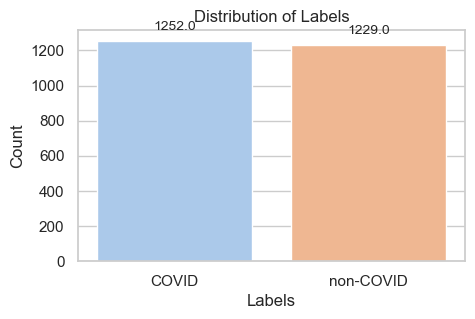

In [26]:
import seaborn as sns
sns.set(style='whitegrid')

# Plot the distribution using seaborn
plt.figure(figsize=(5, 3))
ax = sns.countplot(x='Label', data=image_df, palette='pastel')

# Customize the plot
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(fontsize=12)

# Add data labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Show the plot
plt.show()

In [31]:
image_df['Label'].value_counts()

Label
COVID        1252
non-COVID    1229
Name: count, dtype: int64

# 🔭Visualizing images from the dataset

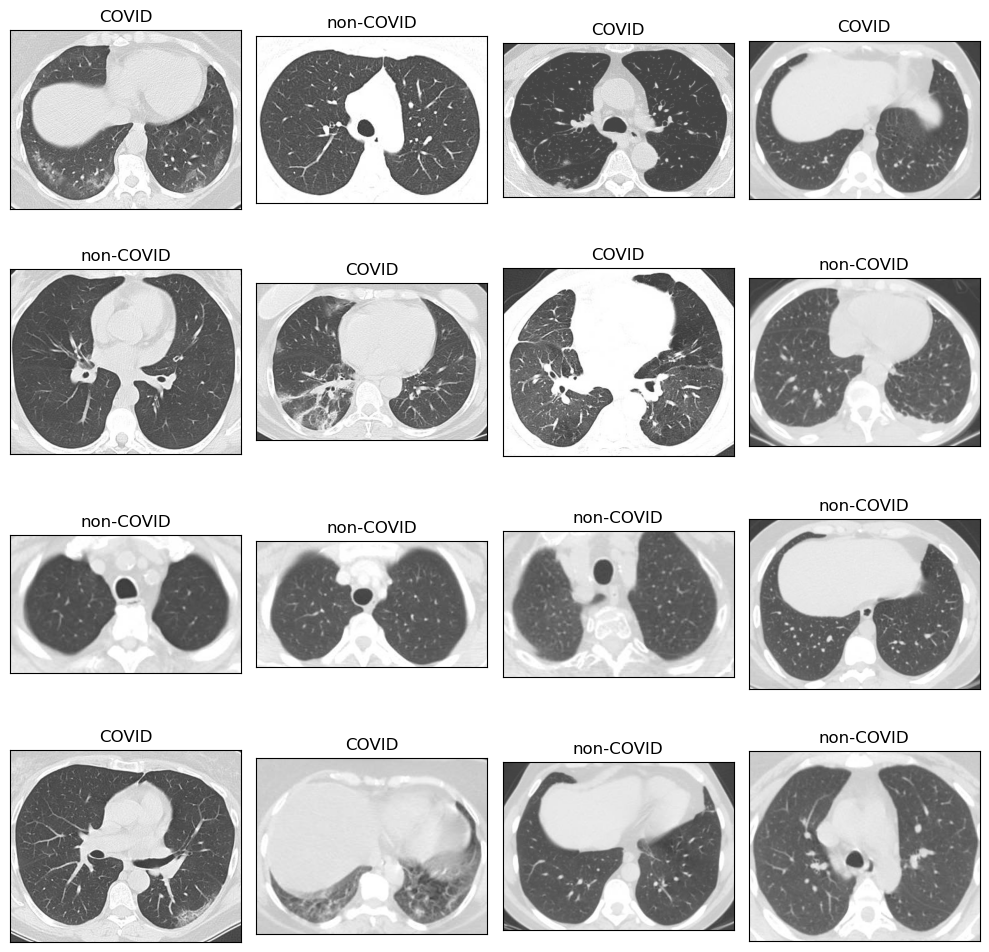

In [17]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [52]:
import os
import pandas as pd
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fonction pour prétraiter une seule image (redimensionnement, conversion en RGB et normalisation)
def preprocess_image(image_path, target_size=(320, 320)):
    # Charger l'image avec un redimensionnement automatique à la taille cible
    img = load_img(image_path, target_size=target_size)
    
    # Convertir l'image en tableau numpy
    img_array = img_to_array(img)
    
    # Si l'image est RGBA (4 canaux), on la convertit en RGB (en enlevant le canal alpha)
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]  # Garder les 3 premiers canaux (RGB)
    
    # Normalisation des pixels (entre 0 et 1)
    img_array = img_array / 255.0
    
    return img_array

# Fonction pour prétraiter toutes les images dans le DataFrame
def preprocess_images_from_dataframe(image_df, target_size=(320, 320)):
    images = []
    labels = []
    
    # Parcourir toutes les lignes du DataFrame
    for _, row in image_df.iterrows():
        image_path = row['Filepath']
        label = row['Label']
        
        # Appliquer le prétraitement à chaque image
        img_array = preprocess_image(image_path, target_size)
        
        # Ajouter l'image et l'étiquette à la liste
        images.append(img_array)
        labels.append(label)
    
    # Convertir la liste d'images en un tableau numpy
    images = np.array(images)
    
    # Convertir les labels en tableau numpy
    labels = np.array(labels)
    
    return images, labels

# Charger vos chemins d'images et labels depuis le dataset
image_dir = Path("C:/Users/singa/Documents/S3/Projet_M2/archive/COVID_Dataset")  # Modifier selon votre dossier

# Obtenir les chemins des fichiers et les labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convertir en DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenation des chemins d'images et des labels
image_df = pd.concat([filepaths, labels], axis=1)

# Appliquer le prétraitement
images, labels = preprocess_images_from_dataframe(image_df)

# Vérifier la forme des images et labels
print(f"Forme des images : {images.shape}")
print(f"Forme des labels : {labels.shape}")

Forme des images : (2481, 320, 320, 3)
Forme des labels : (2481,)


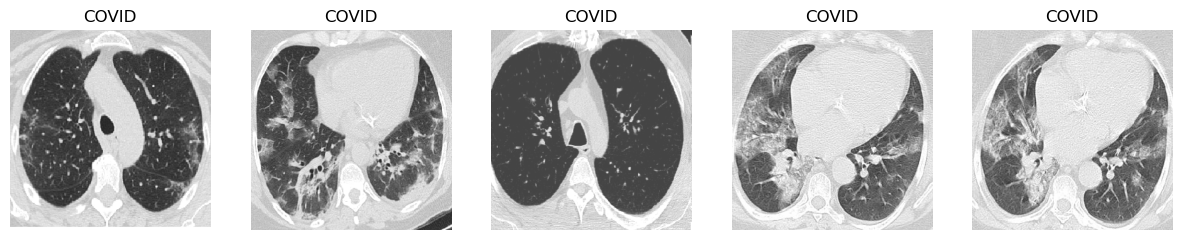

In [29]:
import matplotlib.pyplot as plt

def display_images(images, labels, n=5):
    """
    Affiche les premières n images du tableau 'images' avec leurs labels.
    """
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])  # Affiche l'image
        plt.title(labels[i])    # Affiche le label associé
        plt.axis('off')         # Cache les axes
    plt.show()

# Afficher les 5 premières images traitées
display_images(images, labels, n=5)

In [54]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [56]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [58]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1588 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 497 validated image filenames belonging to 2 classes.


In [60]:
# Resize Layer
#resize_and_rescale = tf.keras.Sequential([
#  layers.experimental.preprocessing.Resizing(224,224),
#  layers.experimental.preprocessing.Rescaling(1./255),
#])

from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(224, 224),  # Redimensionne à 224x224
    Rescaling(1./255),   # Normalise les pixels entre 0 et 1
])


# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (320, 320, 3)

**Output layer** : 1



In [62]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [64]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

#from tensorflow.keras.callbacks import ModelCheckpoint


In [66]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [68]:
def create_tensorboard_callback(log_dir, experiment_name):
    """Crée un callback TensorBoard pour suivre les logs."""
    log_path = os.path.join(log_dir, experiment_name)
    print(f"Logging TensorBoard logs à : {log_path}")
    return tf.keras.callbacks.TensorBoard(log_dir=log_path)

In [70]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [72]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,652,226 (10.12 MB)

 Trainable params: 394,242 (1.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Logging TensorBoard logs à : training_logs\fire_classification


D:\anacon\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 775ms/step - accuracy: 0.6008 - loss: 0.6921 - val_accuracy: 0.8207 - val_loss: 0.4490
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 743ms/step - accuracy: 0.7910 - loss: 0.4498 - val_accuracy: 0.8636 - val_loss: 0.3520
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 738ms/step - accuracy: 0.8617 - loss: 0.3418 - val_accuracy: 0.8889 - val_loss: 0.3064
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 738ms/step - accuracy: 0.8704 - loss: 0.3145 - val_accuracy: 0.9040 - val_loss: 0.2730
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 736ms/step - accuracy: 0.8900 - loss: 0.2661 - val_accuracy: 0.9091 - val_loss: 0.2496
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 720ms/step - accuracy: 0.9095 - loss: 0.2397 - val_accuracy: 0.9040 - val_loss: 0.2432
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 714ms/step - accuracy: 0.9240 - loss: 0.1839 - val_accuracy: 0.9066 - val_loss: 0.2256
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 738ms/step - accuracy: 0.9392 - loss: 0.1743 - 

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [68]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

D:\anacon\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.16115
Test Accuracy: 93.76%


# 📉Visualizing loss curves

In [70]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """Affiche les courbes de perte et d'exactitude pour l'entraînement et la validation."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history.get('accuracy', history.history.get('acc'))
    val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

    epochs = range(len(loss))  # Nombre d'époques

    # Courbe de perte
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Perte d'entraînement")
    plt.plot(epochs, val_loss, label="Perte de validation")
    plt.title("Perte")
    plt.xlabel("Époques")
    plt.legend()

    # Courbe d'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Exactitude d'entraînement")
    plt.plot(epochs, val_accuracy, label="Exactitude de validation")
    plt.title("Exactitude")
    plt.xlabel("Époques")
    plt.legend()

    plt.show()


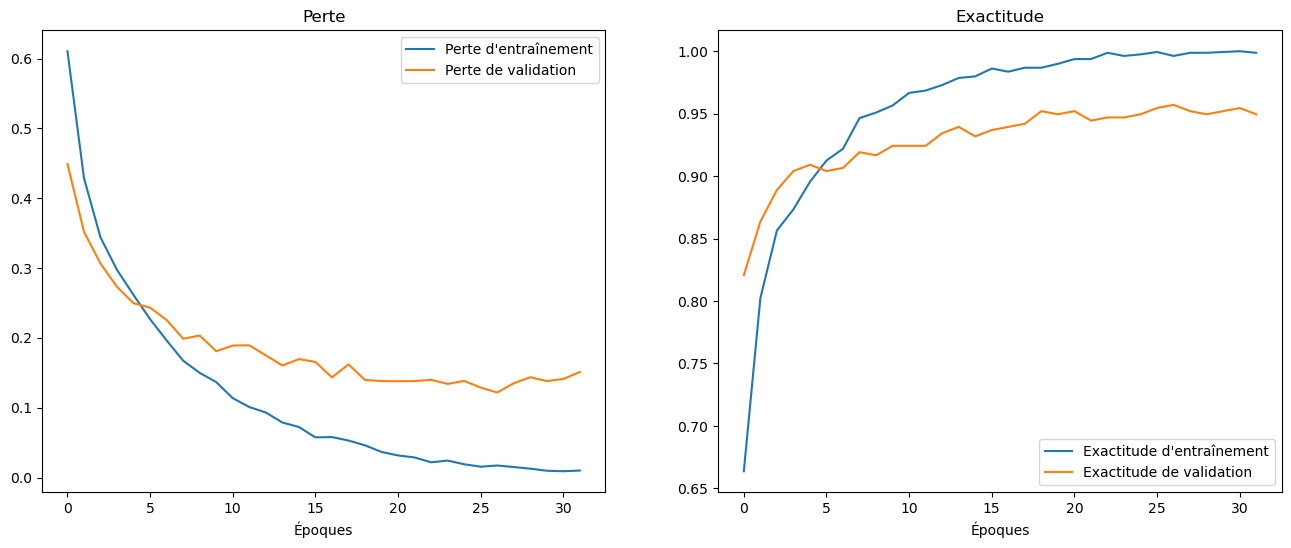

In [72]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [74]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step
The first 5 predictions: ['COVID', 'COVID', 'non-COVID', 'non-COVID', 'COVID']


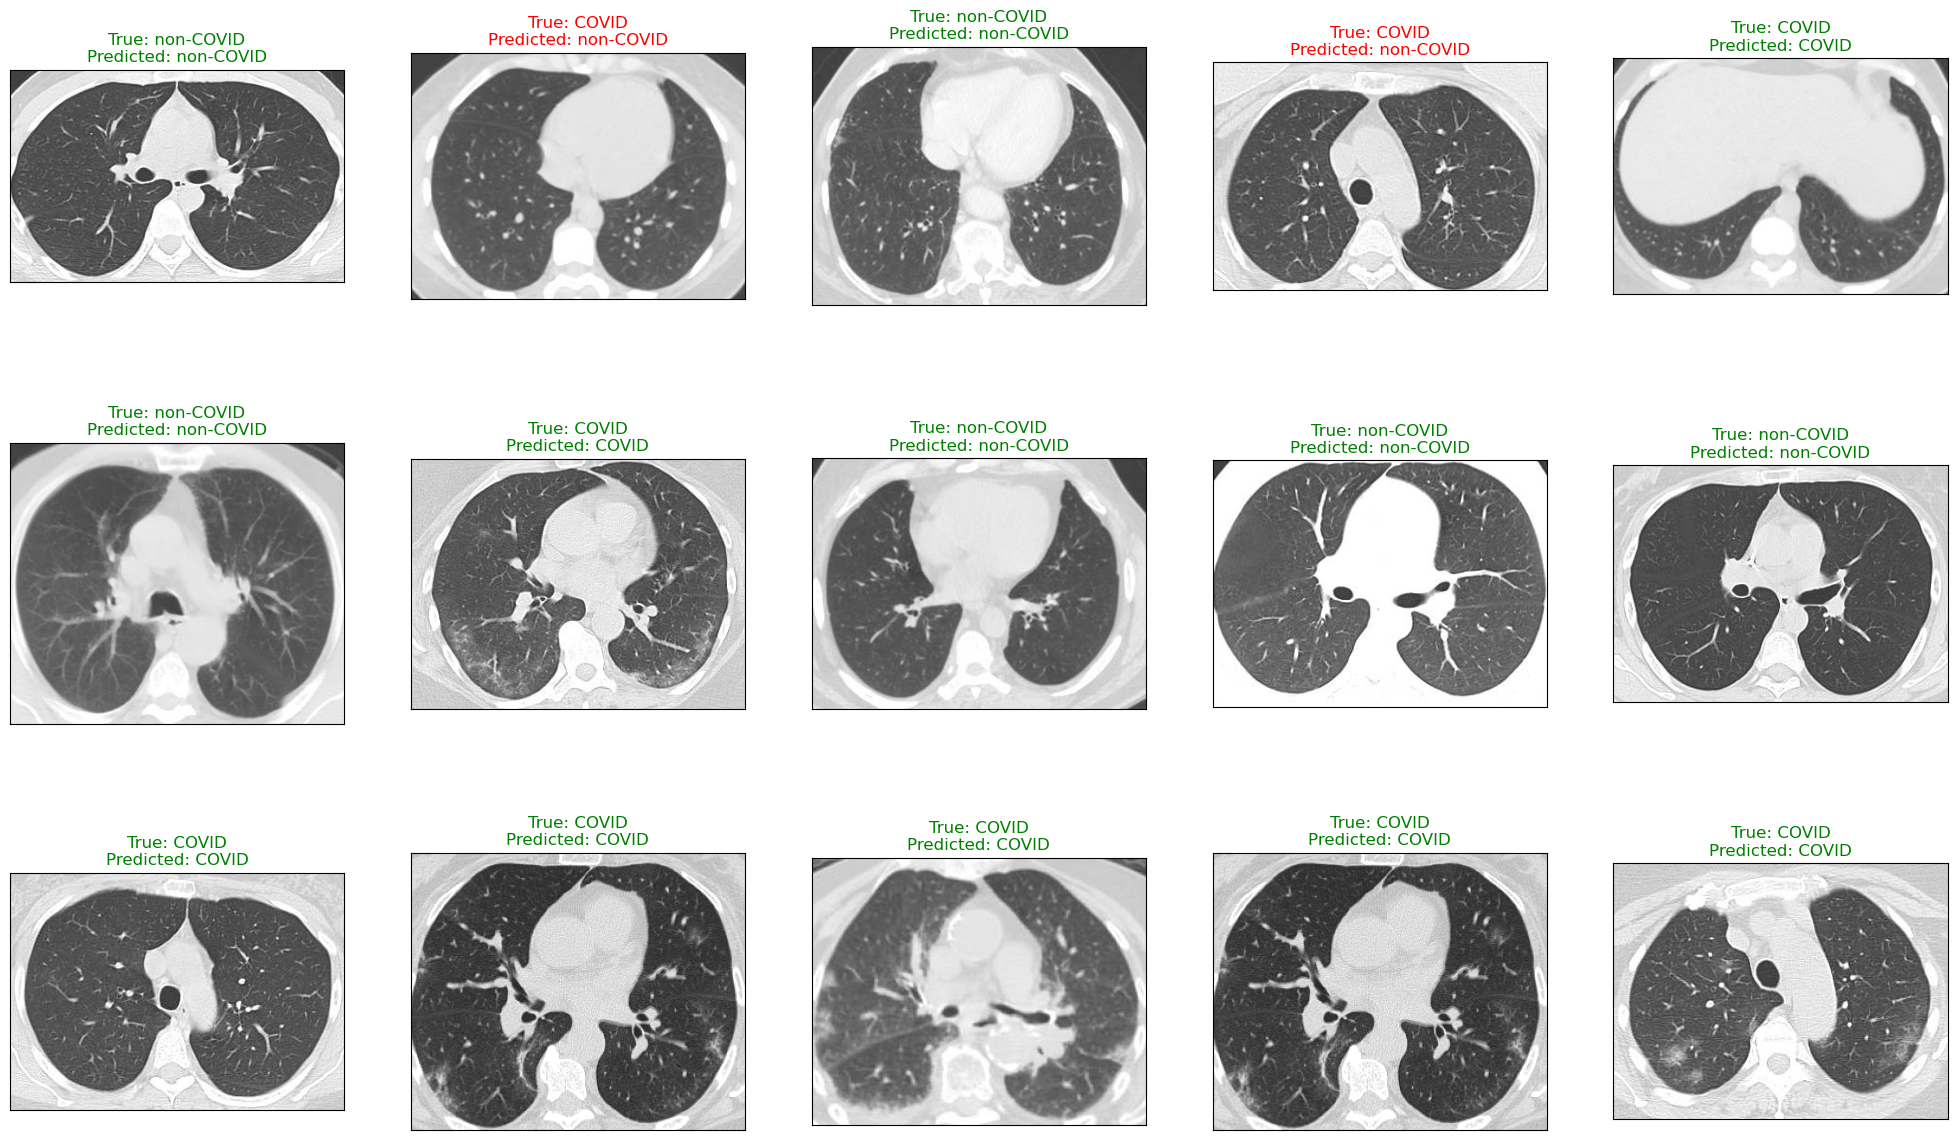

<Figure size 640x480 with 0 Axes>

In [76]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [78]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       COVID       0.92      0.95      0.94       239
   non-COVID       0.96      0.92      0.94       258

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497



In [80]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
COVID,0.919355,0.953975,0.936345,239.000000
non-COVID,0.955823,0.922481,0.938856,258.000000
accuracy,0.937626,0.937626,0.937626,0.937626
macro avg,0.937589,0.938228,0.937600,497.000000
weighted avg,0.938286,0.937626,0.937648,497.000000


In [82]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


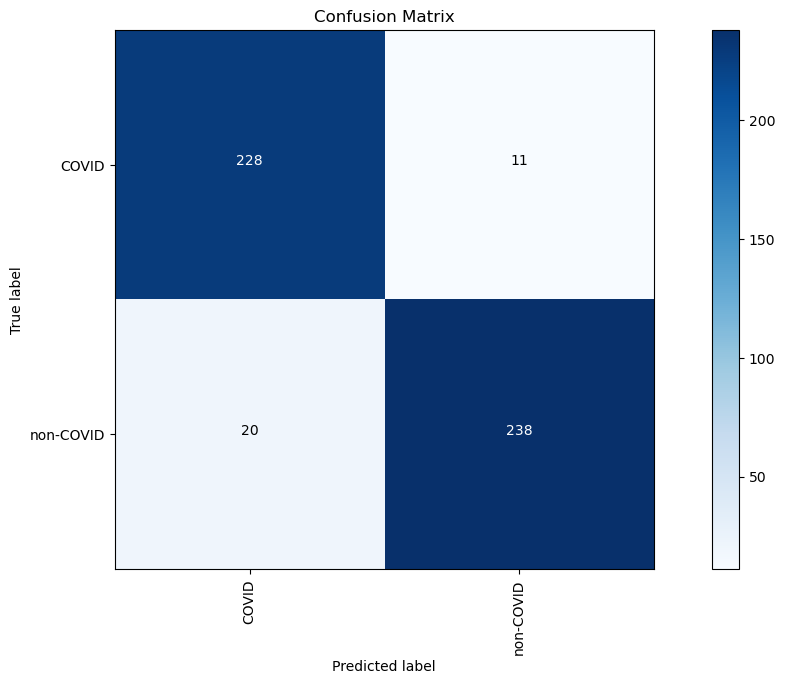

In [84]:
make_confusion_matrix(y_test, pred, list(labels.values()))

### Thanks for viewing the notebook. I would greatly appreciate any feedback, suggestions and recommendations for improvement. Cheers! 

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>